## View GeoTiff files as images and Metadata

#### Visualize Sample Images

----------------------------------------------------------------------
Examining pixel at position (x=100, y=100)
----------------------------------------------------------------------

1. ORIGINAL RAW VALUES (from satellite):
   Red:   947
   Green: 1113
   Blue:  1351

2. NORMALIZED FOR DISPLAY (divided by 3000):
   Red:   0.316
   Green: 0.371
   Blue:  0.450

3. INTERPRETATION:
   - Bluish = Likely water

4. FULL IMAGE VALUE RANGES:
   Red:   555 to 1280
   Green: 847 to 1286
   Blue:  1205 to 1392


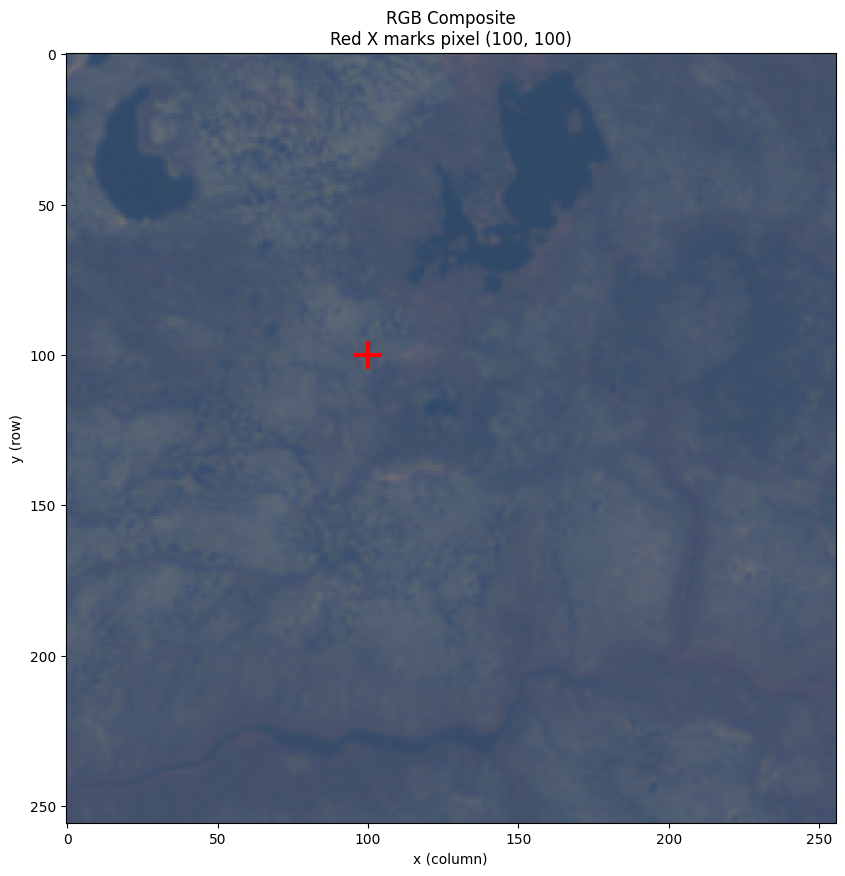

In [5]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np


s2_file = 'E:\\AgriML Projects\\CropLEM\\data\\sen12ms\\ROIs1868_summer_s2\\ROIs1868_summer\\s2_4\\ROIs1868_summer_s2_4_p30.tif'

with rasterio.open(s2_file) as src:
    # Read RGB bands
    red = src.read(3)
    green = src.read(2)
    blue = src.read(1)
    
    # Pick one specific pixel to examine
    x, y = 100, 100
    
    print("-" * 70)
    print(f"Examining pixel at position (x={x}, y={y})")
    print("-" * 70)
    
    print("\n1. ORIGINAL RAW VALUES (from satellite):")
    print(f"   Red:   {red[y, x]}")
    print(f"   Green: {green[y, x]}")
    print(f"   Blue:  {blue[y, x]}")
    
    print("\n2. NORMALIZED FOR DISPLAY (divided by 3000):")
    red_norm = red[y, x] / 3000
    green_norm = green[y, x] / 3000
    blue_norm = blue[y, x] / 3000
    print(f"   Red:   {red_norm:.3f}")
    print(f"   Green: {green_norm:.3f}")
    print(f"   Blue:  {blue_norm:.3f}")
    
    print("\n3. INTERPRETATION:")
    if green_norm > red_norm and green_norm > blue_norm:
        print("   - Greenish = Likely vegetation")
    elif red_norm > green_norm and red_norm > blue_norm:
        print("   - Reddish = Likely bare soil or urban")
    elif blue_norm > red_norm and blue_norm > green_norm:
        print("   - Bluish = Likely water")
    else:
        print("   - Grayish = Likely clouds or mixed surface")
    
    print("\n4. FULL IMAGE VALUE RANGES:")
    print(f"   Red:   {red.min()} to {red.max()}")
    print(f"   Green: {green.min()} to {green.max()}")
    print(f"   Blue:  {blue.min()} to {blue.max()}")
    
    # Display the image
    rgb = np.stack([red, green, blue], axis=-1)
    rgb = np.clip(rgb / 3000, 0, 1)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(rgb)
    plt.plot(x, y, 'r+', markersize=20, markeredgewidth=3)  # Mark the pixel we examined
    plt.title(f"RGB Composite\nRed X marks pixel ({x}, {y})")
    plt.xlabel("x (column)")
    plt.ylabel("y (row)")
    plt.show()

#### View Detailed Metadata

In [ ]:
from pprint import pprint

def show_complete_metadata(filepath):
    """Display all metadata in organized format"""
    
    with rasterio.open(filepath) as src:
        print(f"COMPLETE METADATA FOR: {filepath.split('/')[-1]}")
        
        # 1. BASIC PROPERTIES
        print("BASIC PROPERTIES")
        print("-" * 70)
        metadata_dict = {
            'Driver': src.driver,
            'Width': src.width,
            'Height': src.height,
            'Band Count': src.count,
            'Data Types': src.dtypes,
            'NoData Values': src.nodatavals,
            'File Size (bytes)': src.profile.get('blockxsize', 'N/A'),
        }
        for key, value in metadata_dict.items():
            print(f"{key:20s}: {value}")
        
        # 2. SPATIAL REFERENCE
        print("\nSPATIAL REFERENCE")
        print("-" * 70)
        print(f"CRS: {src.crs}")
        print(f"CRS (EPSG code): {src.crs.to_epsg() if src.crs else 'N/A'}")
        print(f"\nBounds:")
        print(f"  Left:   {src.bounds.left:.6f}")
        print(f"  Bottom: {src.bounds.bottom:.6f}")
        print(f"  Right:  {src.bounds.right:.6f}")
        print(f"  Top:    {src.bounds.top:.6f}")
        
        center_lon = (src.bounds.left + src.bounds.right) / 2
        center_lat = (src.bounds.top + src.bounds.bottom) / 2
        print(f"\nCenter: ({center_lat:.6f}, {center_lon:.6f})")
        print(f"View on map: https://www.google.com/maps/@{center_lat},{center_lon},14z")
        
        # 3. TRANSFORM
        print("\nAFFINE TRANSFORM")
        print("-" * 70)
        print("(Converts pixel coordinates to geographic coordinates)")
        print(src.transform)
        print(f"\nPixel size: {src.res[0]} x {src.res[1]} meters")
        
        # Calculate area
        area_m2 = src.width * src.height * abs(src.res[0] * src.res[1])
        area_km2 = area_m2 / 1_000_000
        print(f"Total area: {area_km2:.2f} km² ({area_m2:.0f} m²)")
        
        # 4. BAND-SPECIFIC METADATA
        print("\nBAND INFORMATION")
        print("-" * 70)
        
        # Sentinel-2 band names
        s2_band_names = {
            1: 'B02 (Blue)',
            2: 'B03 (Green)', 
            3: 'B04 (Red)',
            4: 'B05 (Red Edge 1)',
            5: 'B06 (Red Edge 2)',
            6: 'B07 (Red Edge 3)',
            7: 'B08 (NIR)',
            8: 'B8A (Narrow NIR)',
            9: 'B09 (Water Vapor)',
            10: 'B10 (Cirrus)',
            11: 'B11 (SWIR 1)',
            12: 'B12 (SWIR 2)',
            13: 'B01 (Coastal Aerosol)'
        }
        
        for band_num in range(1, src.count + 1):
            band_name = s2_band_names.get(band_num, f'Band {band_num}')
            print(f"\n{band_name}:")
            print(f"  Index: {band_num}")
            print(f"  Data type: {src.dtypes[band_num - 1]}")
            print(f"  NoData: {src.nodatavals[band_num - 1]}")
            
            # Read band statistics (sample first 1000 pixels for speed)
            band_data = src.read(band_num)
            sample = band_data.flatten()[:1000]
            sample = sample[~np.isnan(sample)]
            
            if len(sample) > 0:
                print(f"  Min value: {sample.min():.2f}")
                print(f"  Max value: {sample.max():.2f}")
                print(f"  Mean: {sample.mean():.2f}")
                print(f"  Std: {sample.std():.2f}")
        
        # 5. RASTERIO PROFILE
        print("\nRASTERIO PROFILE")
        print("-" * 70)
        pprint(src.profile)
        
        # 6. ADDITIONAL TAGS
        print("\nADDITIONAL METADATA TAGS")
        print("-" * 70)
        tags = src.tags()
        if tags:
            pprint(tags)
        else:
            print("No additional metadata tags found")
        
        print("\n" + "=" * 70 + "\n")

# Run it
show_complete_metadata('E:\\AgriML Projects\\CropLEM\\data\\sen12ms\\ROIs1868_summer_s2\\ROIs1868_summer\\s2_4\\ROIs1868_summer_s2_4_p30.tif')

COMPLETE METADATA FOR: E:\AgriML Projects\CropLEM\data\sen12ms\ROIs1868_summer_s2\ROIs1868_summer\s2_4\ROIs1868_summer_s2_4_p30.tif
BASIC PROPERTIES
----------------------------------------------------------------------
Driver              : GTiff
Width               : 256
Height              : 256
Band Count          : 13
Data Types          : ('uint16', 'uint16', 'uint16', 'uint16', 'uint16', 'uint16', 'uint16', 'uint16', 'uint16', 'uint16', 'uint16', 'uint16', 'uint16')
NoData Values       : (None, None, None, None, None, None, None, None, None, None, None, None, None)
File Size (bytes)   : 256

SPATIAL REFERENCE
----------------------------------------------------------------------
CRS: EPSG:32640
CRS (EPSG code): 32640

Bounds:
  Left:   417903.596410
  Bottom: 7569866.855528
  Right:  420463.596410
  Top:    7572426.855528

Center: (7571146.855528, 419183.596410)
View on map: https://www.google.com/maps/@7571146.855528089,419183.59640957054,14z

AFFINE TRANSFORM
-----------------

#### Compare Sentinel-1 and Sentinel-2 Metadata

In [2]:
def compare_s1_s2_metadata(s1_file, s2_file):
    """Compare metadata between S1 and S2 patches"""
    
    print("SENTINEL-1 vs SENTINEL-2 METADATA COMPARISON")
    
    with rasterio.open(s1_file) as s1, rasterio.open(s2_file) as s2:
        
        comparison = {
            'Property': ['Number of Bands', 'Data Type', 'Width', 'Height', 
                        'Pixel Size (m)', 'CRS', 'Center Lat', 'Center Lon'],
            'Sentinel-1 (SAR)': [
                s1.count,
                str(s1.dtypes[0]),
                s1.width,
                s1.height,
                f"{s1.res[0]:.1f}",
                str(s1.crs),
                f"{(s1.bounds.top + s1.bounds.bottom)/2:.6f}",
                f"{(s1.bounds.left + s1.bounds.right)/2:.6f}"
            ],
            'Sentinel-2 (Optical)': [
                s2.count,
                str(s2.dtypes[0]),
                s2.width,
                s2.height,
                f"{s2.res[0]:.1f}",
                str(s2.crs),
                f"{(s2.bounds.top + s2.bounds.bottom)/2:.6f}",
                f"{(s2.bounds.left + s2.bounds.right)/2:.6f}"
            ]
        }
        
        # Print as table
        print(f"{'Property':<25} {'Sentinel-1 (SAR)':<30} {'Sentinel-2 (Optical)':<30}")
        print("-" * 85)
        
        for i, prop in enumerate(comparison['Property']):
            s1_val = comparison['Sentinel-1 (SAR)'][i]
            s2_val = comparison['Sentinel-2 (Optical)'][i]
            match = "Matched" if s1_val == s2_val else "Not Matched"
            print(f"{prop:<25} {s1_val:<30} {s2_val:<30} {match}")
        
        print("\n" + "=" * 85 + "\n")


s1_file = 'E:\\AgriML Projects\\CropLEM\\data\\sen12ms\\ROIs1868_summer_s1\\ROIs1868_summer\\s1_4\\ROIs1868_summer_s1_4_p30.tif'
s2_file = 'E:\\AgriML Projects\\CropLEM\\data\\sen12ms\\ROIs1868_summer_s2\\ROIs1868_summer\\s2_4\\ROIs1868_summer_s2_4_p30.tif'

compare_s1_s2_metadata(s1_file, s2_file)

SENTINEL-1 vs SENTINEL-2 METADATA COMPARISON
Property                  Sentinel-1 (SAR)               Sentinel-2 (Optical)          
-------------------------------------------------------------------------------------
Number of Bands           2                              13                             Not Matched
Data Type                 float32                        uint16                         Not Matched
Width                     256                            256                            Matched
Height                    256                            256                            Matched
Pixel Size (m)            10.0                           10.0                           Matched
CRS                       EPSG:32640                     EPSG:32640                     Matched
Center Lat                7571146.855528                 7571146.855528                 Matched
Center Lon                419183.596410                  419183.596410                  Matched




#### Extract Metadata for Geographic location

In [3]:
from pyproj import Transformer

def find_location(filepath):
    """Determine what region/country this patch is from"""
    
    with rasterio.open(filepath) as src:
        # Get center point
        bounds = src.bounds
        center_lon = (bounds.left + bounds.right) / 2
        center_lat = (bounds.top + bounds.bottom) / 2
        
        # If CRS is not lat/lon, convert it
        if src.crs and not src.crs.is_geographic:
            transformer = Transformer.from_crs(src.crs, "EPSG:4326", always_xy=True)
            center_lon, center_lat = transformer.transform(center_lon, center_lat)
        
        print(f"\nLOCATION INFORMATION")
        print("-" * 70)
        print(f"File: {filepath.split('/')[-1]}")
        print(f"Center coordinates: ({center_lat:.6f}, {center_lon:.6f})")
        
        # Determine region based on coordinates
        region = "Unknown"
        if -180 <= center_lon <= -30:
            region = "Americas"
        elif -30 < center_lon <= 60:
            if center_lat > 35:
                region = "Europe"
            elif center_lat < 0:
                region = "Africa"
            else:
                region = "Middle East/North Africa"
        elif 60 < center_lon <= 150:
            region = "Asia"
        elif 150 < center_lon <= 180:
            region = "Oceania/Pacific"
        
        print(f"Approximate region: {region}")
        print(f"\nView on Google Maps:")
        print(f"  https://www.google.com/maps/@{center_lat},{center_lon},12z")
        print(f"\nView on OpenStreetMap:")
        print(f"  https://www.openstreetmap.org/#map=12/{center_lat}/{center_lon}")
        print("-" * 70 + "\n")

# Test it
find_location('E:\\AgriML Projects\\CropLEM\\data\\sen12ms\\ROIs1868_summer_s2\\ROIs1868_summer\\s2_4\\ROIs1868_summer_s2_4_p30.tif')


LOCATION INFORMATION
----------------------------------------------------------------------
File: E:\AgriML Projects\CropLEM\data\sen12ms\ROIs1868_summer_s2\ROIs1868_summer\s2_4\ROIs1868_summer_s2_4_p30.tif
Center coordinates: (68.242191, 55.046103)
Approximate region: Europe

View on Google Maps:
  https://www.google.com/maps/@68.24219128548256,55.04610291764085,12z

View on OpenStreetMap:
  https://www.openstreetmap.org/#map=12/68.24219128548256/55.04610291764085
----------------------------------------------------------------------

